<a href="https://colab.research.google.com/github/dineshRaja29/Revenue-Forecast-Engine/blob/main/ShriRadheyPayPay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Shri Radhey

#<font color='green'><b>INTRODUCTION</b></font>


##<font color='green'><b>BUSINESS PROBLEM

YayYay is a small payment processing company based in Japan that began operations in 2019. The business team is interested in forecasting GMV (Gross Merchandise Value), which is defined as the sum of transaction amounts over a period of time. GMV can be defined per store (the seller), per user (the purchaser), or for YayYay as a whole (across all users and stores).



##<font color='green'><b>PROBLEM DEFINITION

* Perform an exploratory data analysis to highlight patterns in the data using whatever visualizations you prefer.
* Forecast GMV for each user for the month of January 2022
* Forecast GMV for YayYay as a whole for each date in the month of January 2022

##<font color='green'><b>REAL-WORLD/BUSINESS OBJECTIVES AND CONSTRAINTS




OBJECTIVE:
Predict the GMV as accurate as possibile

CONSTRAINTS:

* No low-latency requirement
* Interpretability is partial important
* Errors can be very costly
* Relative error should be less

##<font color='green'><b>DATA DETAILS

The datasets is given in CSV format and split across three files. Below are the file details.
* <b>transactions.csv</b> contains all transactions for 2020 and 2021 including the user ID (user_id), store ID (store_id), the datetime of the transaction (event_occurance), and the amount of the transaction in yen (amount)

* <b>Stores.csv</b> contains characteristics for each store such as the prefecture (nam), local administrative area (laa), category, and location in latitude (lat) and longitude (lon)

* <b>Users.csv</b> contains the characteristics for each user such as gender and age as of December 31, 2021



##<font color='green'><b>MAPPING THE REAL-WORLD PROBLEM TO AN ML PROBLEM




###<font color='green'><b>ML PROBLEM FORMULATION</b></font>
There are 16 types of store, and each user on each day spend some amount on the stores. Thus, it is a standard regression problem.

##<font color='green'><b>PERFORMANCE METRIC


* Mean Absolute Percentage Error (MAPE)
> Quantifies the error percentage which directly helps to understand the how far we are with actual prediction

* R2 Score
> Helps to monitor how good we are when we compare to the model which predicts the average values for each observation



#<font color='green'><b>IMPORT LIBRARIES AND CONFIGURATION VARIABLES</b></font>

In [ ]:
!pip install reverse_geocoder > /dev/null

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
import pprint
import folium
import calendar
import datetime
import holidays
from sklearn.decomposition import PCA
import reverse_geocoder as rg
from geopy.geocoders import Nominatim
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import seaborn as sns
import sklearn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import random
from scipy.stats import kurtosis, skew
geolocator = Nominatim(user_agent="geoapiExercises")

In [ ]:
# plot like definers
font = {'weight' : 'bold',
        'size'   : 12}
plt.rc('font', **font)
sns.set_theme(color_codes=True)
%matplotlib inline

In [ ]:
# compressing unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# accessing the drive to get the data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# GLOBAL CONSTANT AND FUNCTIONS
dictMapping = { "ATMチャージ" : "ATMcharge", \
                "その他" : "others", \
                "エンタメ" : "Entertainment", \
                "カフェ" : "Cafe", \
                "クリーニング" : "cleaning", \
                "グルメ" : "Gourmet", \
                "コンビニ" : "convenienceStore", \
                "ショッピング" : "shopping", \
                "スーパーマーケット" : "supermarket", \
                "ドラッグストア・薬局" : "Pharmacy", \
                "ファッション" : "fashion", \
                "ホテル・旅館" : "Hotel", \
                "マッサージ" : "Massage", \
                "家電・携帯電話" : "Appliances", \
                "病院・クリニック" : "Hospital", \
                "百貨店・ショッピングセンター" : "shoppingCenter", \
                "美容院・サロン" : "salon" }

JAPAN_HOLIDAYS = {}
for holiday in holidays.Japan(years=[2020, 2021, 2022]).items():
    if holiday in JAPAN_HOLIDAYS:
        pass
    else:
        keys = str(holiday[0]).strip().split('-')
        key = '-'.join(keys[:2])
        JAPAN_HOLIDAYS[key] = True

# adding the City and state
def geocoder(data):
    results = rg.search(data)
    return results

def findDay(date):
    """
    return the day Status
    """
    year, month, day = (int(i) for i in date.split('-'))
    dayNumber = calendar.weekday(year, month, day)
    return dayNumber

def weekDayORweekEnd(date):
    """
    return the status of date as weekend or weekday
    """
    year, month, day = (int(i) for i in date.split('-'))
    dayNumber = calendar.weekday(year, month, day)
    if dayNumber >= 5 and dayNumber <= 6:
        return 1
    else:
        return 0

def QuaterStatus(date):
    """
    return the Status of Quarter
    """
    _, month, _ = (int(i) for i in date.split('-'))
    return math.ceil(month / 3)

def numOfDays(date):
    year, month, day = (int(i) for i in date.split('-'))
    dateStart = datetime.date(year, month, day)
    dateEnd = datetime.date(year, 12, 31)
    return (dateEnd - dateStart).days

def IsHolidayInMonth(date):
    keys = date.strip().split('-')
    key = '-'.join(keys[:2])
    if key in JAPAN_HOLIDAYS:
        return 1
    else:
        return 0

def monthStatus(date):
    """
    return the Status of Month
    """
    _, month, _ = (int(i) for i in date.split('-'))
    return month

def dayStatus(date):
    """
    return the Status of Day
    """
    _, _, day = (int(i) for i in date.split('-'))
    return day

def IsMidWeek(date):
    """
    return the Mid-week Status
    """
    year, month, day = (int(i) for i in date.split('-'))
    dayNumber = calendar.weekday(year, month, day)
    if dayNumber == 2:
        return 1
    else:
        return 0

#<font color='green'><b>DATA IMPUTATION</b></font>

In [ ]:
# data loading
stores = pd.read_csv('drive/MyDrive/PayPayDataset/stores.csv', sep = ',')
stores.rename(columns={'id': 'store_id'}, inplace=True)
transactions = pd.read_csv('drive/MyDrive/PayPayDataset/transactions.csv', sep = ',')
users = pd.read_csv('drive/MyDrive/PayPayDataset/users.csv', sep = ',')
users.rename(columns={'id': 'user_id'}, inplace=True)

In [ ]:
# merging files
storetranscations = pd.merge(stores, transactions, left_on = 'store_id', right_on = 'store_id', \
                             left_index = False, right_index = False )
dataset = pd.merge(storetranscations, users, left_on = 'user_id', right_on = 'user_id', \
                            left_index = False, right_index = False )

In [ ]:
dataset.describe()

,lat,lon,amount,age
count,1.582260e+06,1.582260e+06,1.582260e+06,1.505614e+06
mean,3.553551e+01,1.370689e+02,1.703913e+03,5.001282e+01
std,2.194248e+00,3.368230e+00,5.361803e+03,1.911783e+01
min,2.435114e+01,1.238093e+02,2.000000e+00,1.500000e+01
25%,3.467408e+01,1.353256e+02,3.320000e+02,3.400000e+01
50%,3.538779e+01,1.379939e+02,7.320000e+02,4.900000e+01
75%,3.586862e+01,1.397033e+02,1.675000e+03,6.500000e+01
max,4.543397e+01,1.461748e+02,1.883119e+06,9.000000e+01


In [ ]:
dataset.dtypes

store_id             object
nam                  object
laa                  object
category             object
lat                 float64
lon                 float64
id                   object
user_id              object
event_occurrence     object
amount                int64
gender               object
age                 float64
dtype: object

In [ ]:
print(dataset.isnull().sum())

store_id                 0
nam                      0
laa                      0
category                 0
lat                      0
lon                      0
id                       0
user_id                  0
event_occurrence         0
amount                   0
gender              160282
age                  76646
dtype: int64


In [ ]:
#  'gender' field is a categorical so we thought the missing value could be considered a field
dataset['gender'].fillna('NOTDEFINED', inplace = True)
print(dataset.isnull().sum())

store_id                0
nam                     0
laa                     0
category                0
lat                     0
lon                     0
id                      0
user_id                 0
event_occurrence        0
amount                  0
gender                  0
age                 76646
dtype: int64


In [ ]:
"""
 'age' field is a real value in nature thus a brute force solution is to replace
 the value with the average of the column however we thought it is making more
 sense to fill this value based on considering the field 'category' field because certain
 age of people visits a certain kind of stores. Thus, we replace age with the grouping
 of the 'category' field's median value.
"""
ageImputation = dict(dataset.groupby(['category']).median()['age'])
for idx, row in dataset.iterrows():
    if math.isnan(row.age):
        if row.category in ageImputation:
            dataset.loc[idx, 'age'] = float(int(ageImputation[row.category]))

In [ ]:
dataset.isnull().sum()

store_id            0
nam                 0
laa                 0
category            0
lat                 0
lon                 0
id                  0
user_id             0
event_occurrence    0
amount              0
gender              0
age                 0
dtype: int64

##<font color='green'><b>CONCLUSION</b></font>

> - *We saw two fields namely age and gender having the Null.*
> - *The 'gender' field is categorical so we thought the missing value could be considered a field.*
> - *The 'age' field is real value in nature thus a brute force solution is to replace the value with the average of the column however we thought it is making more sense to fill this value based on considering the field ''category' because certain age of people visits a certain kind of stores. Thus, we replace age with the grouping of the 'category' field's median value.*

#<font color='green'><b>EXPLORATORY DATA ANALYSIS (EDA)</b></font>

The attribute details are
* "store_id": Unique ID for defining the unique store, alphanumeric attribute
* "nam": Text attribute
* "laa": Text attribute
* "category": A categorical attribute
* "lat": A real-value attribute
* "lon": A real-value attribute
* "id": Unique Identifier for identifying the transactions
* "user_id": Unique ID for defining the unique user, alphanumeric attribute
* "event_occurrence": Event Id alphanumeric attribute
* "amount": A real-value attribute
* "gender": A categorical attribute
* "age": A real-value attribute

##<font color='green'><b>UNIVARIATE ANALYSIS</b></font>



###<font color='green'><b>AMOUNT PATTERN </b></font>

* Spending power analysis for each user

In [ ]:
 dataset['event_occurrence_temp'] = dataset['event_occurrence'].apply(lambda x: int(x.split()[0].replace('-', '')))
 dataset_sorted = dataset.sort_values(['event_occurrence_temp', 'user_id', 'store_id'], ascending = True)

In [ ]:
dataset_sorted = dataset_sorted[dataset_sorted['amount'] <= 40]

In [ ]:
len(dataset_sorted)

11596

In [ ]:
count = 0
for i, j in dict(dataset_sorted['amount'].value_counts()).items():

    if j >= 0 and j <= 3:
        count += 1
print(count)

13614


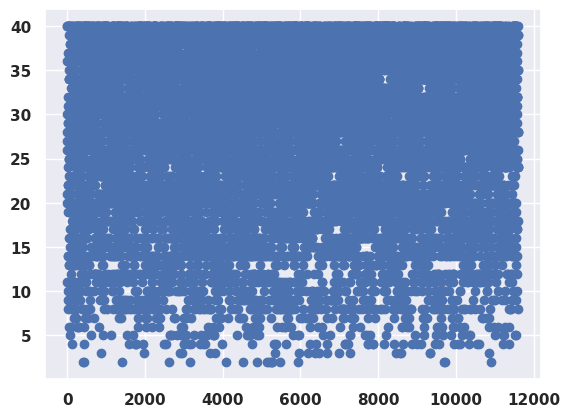

<Figure size 1500x800 with 0 Axes>

In [ ]:
import matplotlib.ticker as ticker
formatter = ticker.ScalarFormatter()
formatter.set_powerlimits((0,1000))
plt.gca().yaxis.set_major_formatter(formatter)
plt.scatter(range(1, len(dataset_sorted['amount']) + 1), dataset_sorted['amount'])
plt.figure(figsize=(15, 8))
plt.show()

In [ ]:
y = sorted(set(dataset['amount'].values))
plt.plot( y)
plt.xlabel('transcations Index')
plt.ylabel('amount spent')
plt.title('Amount Spend per transcation')
plt.grid()
plt.show()

In [ ]:
y = sorted(set(dataset['amount'].values))
plt.plot( y)
plt.xlabel('transcations Index')
plt.ylabel('amount spent')
plt.title('Amount Spend per transcation')
plt.grid()
plt.show()

In [ ]:
# cheking the percantage above 9000
LIMIT = 9000
filtervalues = sorted([i for i in dataset['amount'].values if i > LIMIT ])
print('Percentage of values above {} is {}'.format(LIMIT, (len(filtervalues) * 100)/len(dataset)))

> - *We saw there is a sudden jump in the amount spent for some transactions. Thus, very very few users are spending large amounts otherwise most of the users spent a nominal amount.*
> - *We've inspected this jump deeper and found that an amount greater than 9000 covers 2.5 % of our entire.*

###<font color='green'><b>AGE PATTERN</b></font>

* Understanding which age group users shop more across all the stores

In [ ]:
dataValues = dataset['age'].values
count = {'11-20' : 0,
        '21-30' : 0, '31-40' : 0,
        '41-50' : 0, '51-60' : 0,
        '61-70' : 0, '71-80' : 0,
        '81-90' : 0}
for data in dataValues:
    if data >= 11 and data <= 20:
        count['11-20'] += 1
    if data >= 21 and data <= 30:
        count['21-30'] += 1
    if data >= 31 and data < 40:
        count['31-40'] += 1
    if data >= 41 and data <= 50:
        count['41-50'] += 1
    if data >= 51 and data <= 60:
        count['51-60'] += 1
    if data >= 61 and data <= 70:
        count['61-70'] += 1
    if data >= 71 and data <= 80:
        count['71-80'] += 1
    if data >= 81 and data <= 90:
        count['81-90'] += 1


plt.figure(figsize=(10, 4))
colors  = ("darkorange", "darkseagreen", "orange", "cyan",
           "hotpink", "lightsteelblue", "coral",  "mediumaquamarine")
explodes = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
plt.pie(np.array(list(count.values())), labels = [ i + " age" for i in count.keys()],
                                                 textprops={'fontsize': 12},
                                                 autopct = '%4.1f',
                                                 startangle= 90,
                                                 radius =2,
                                                 rotatelabels=True,
                                                 shadow = True, explode = explodes)
plt.show()

In [ ]:
sns.boxplot(x=dataset['age'])
plt.title('User Age Distribution per transcations')
plt.grid()
plt.show()

> * If we count the number of user in 10 years of age bin then we saw that the user between ages 40 to 50 years shops more than compare to other age group users.
> * We also observe that users between the age of 35 to 65 years are the majority of users.

###<font color='green'><b>CATEGORY FIELD</b></font>

In [ ]:
%%bash

numberOfcategory=$(cat drive/MyDrive/PayPayDataset/stores.csv | \
                        cut -d ',' -f4 | tail -n+2 | \
                        sort | sort -u | \
                        wc -l)
echo "Total #f Categories are ${numberOfcategory}"
echo -e "\n\nCategories are:::: \n"

for type in $(cat drive/MyDrive/PayPayDataset/stores.csv | \
                cut -d ',' -f4 | tail -n+2 | \
                sort | sort -u)
do
    echo -e "\t${type}"
done


In [ ]:
data = dict(Counter(sorted(dataset['category'].values)))
category_names = list(data.keys())
category_counts = list(data.values())

category_names_translated = []
for i in category_names:
    if i in dictMapping:
        category_names_translated.append(dictMapping[i])
x = list(range(len(category_names_translated)))
plt.figure(figsize=(10, 4))
plt.bar(x, category_counts, color ='green', width = 0.4)
plt.xlabel("Categories")
plt.ylabel("#f transcations")
plt.xticks(x, category_names_translated, fontsize=12, rotation=85)
plt.title("Categories per transcations")
plt.grid()
plt.show()


> - *We see the majority of the transaction is done in the convenience store.*
> - *Among all the 17 categories, only 16 are the categories on which user spend money.*

###<font color='green'><b>GENDER FIELD </b></font>

* Understanding the user characteristics based on their gender

In [ ]:
data = dict(Counter(dataset['gender'].values))
category_names = list(data.keys())
category_counts = list(data.values())
x = list(range(len(category_names)))
plt.figure(figsize=(10, 4))
plt.bar(x, category_counts, color ='green', width = 0.4)
plt.xlabel('Gender')
plt.ylabel("#f transcations")
plt.xticks(x, category_names, fontsize=12, rotation=85)
plt.title("transcations on users based on Gender")
plt.grid()
plt.show()

> - *We saw that the majority of users are Males*

###<font color='green'><b>LAT & LONG FIELD</b></font>

* Analyzing the store coordinates
> Co-ordinates belong to Japan's cities only or should be legitimate enough

In [ ]:
%%bash
cat drive/MyDrive/PayPayDataset/stores.csv | cut -d ',' -f5,6 | tail -n+2 | sort | sort -u > locations.txt

In [ ]:
locations = []
with open('locations.txt') as f:
    lines = f.readlines()
    for line in lines:
        temp = [float(line.split(',')[0]), float(line.split(',')[1])]
        locations.append(temp)

In [ ]:
map_osm = folium.Map(location=[36.2048, 138.2529], tiles='Stamen Toner')

for i in locations[:255]:
    folium.Marker(list((i[0],i[1]))).add_to(map_osm)


In [ ]:
map_osm

> - *We see from the above map plot of points, some of the store co-ordinates are out of Japan or some of them are in sea.*
> - *We know from the Business problem that YayYay is Japan based company thus the stores also belong to Japan only.*


 **Identifying the City which have Maximum transcations**
> We are applying the reverse engineering by finding the cities from Latitude and Longitude. <br>
> The goal is to identify the city which have maximum transcations.

In [ ]:
city = []
for i in dataset[['lat', 'lon']].values:
    coord = (i[0], i[1])
    city.append(coord)
lst = [o for o in geocoder(city)]
attrs = pd.DataFrame(lst)
city_count  = attrs['name'].value_counts()
print('Total number of Cities in which PayPay is present ', len(city_count))
city_count = city_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(x = city_count.index, y = city_count.values, alpha=0.5)
plt.title('YayYay in top 10 cities')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('city', fontsize=12)
plt.show()


> - *Total number of Cities where YayYay is using are 747*
> - *Top 10 Cities where PayPay is majorly using are 'Tokyo', 'Urayasu', 'Kawasaki', 'Yokohama', 'Sapporo', 'Chofugaoka',  'Nagoya-shi', 'Hiroshima-shi', 'Matsudo' and 'Machida' (sorted in increasing order)*

 **Identifying the States which have Maximum transcations**
> We are applying the reverse engineering by finding the states or Prefecture from Latitude and Longitude. <br>
> The goal is to identify the States or Prefecture which have maximum transcations.

In [ ]:
city = []
for i in dataset[['lat', 'lon']].values:
    coord = (i[0], i[1])
    city.append(coord)
lst = [o for o in geocoder(city)]
attrs = pd.DataFrame(lst)
prefecture_count  = attrs['admin1'].value_counts()
print('Total number of Prefecture in which PayPay is present ', len(prefecture_count))
prefecture_count = prefecture_count[:10,]
plt.figure(figsize=(15,5))
sns.barplot(x = prefecture_count.index, y = prefecture_count.values, alpha=0.5)
plt.title('YayYay in top 10 Prefecture')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Prefecture', fontsize=12)
plt.show()

> - *Total number of Prefecture where YayYay is using are 51*
> - *Top 10 Prefecture where PayPay is majorly using are 'Tokyo', 'Saitama', 'Kanagawa', 'Osaka', 'Aichi', 'Hyogo', 'Chiba', 'Fukuoka', 'Hokkaido' and 'Shizuoka' (sorted in increasing order)*

###<font color='green'><b>DATE FIELD</b></font>

* We will understand the user or store behaviour based on the date attribute

**Which Day most transcations happens**

In [ ]:
colors  = ("darkorange", "darkseagreen", "orange", "cyan",
           "hotpink", "lightsteelblue", "coral")
explodes = [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]
DAYS = {0 : "Monday", 1 : "Tuesday", 2 : "Wednesday", 3 : "Thursday",
          4 : "Friday", 5 : "Saturday", 6 : "Sunday"}

values = []
labels = []
for i, j in dict(Counter(dataset['event_occurrence'].\
                         apply(lambda x: x.split(' ')[0].strip()).\
                         apply(findDay).values)).items():
    values.append(j)
    labels.append(DAYS[i])

plt.pie(values, \
            labels = labels,
            textprops = {'fontsize': 12},
            autopct = '%4.1f',
            startangle = 90,
            radius = 2,
            rotatelabels =True,
            shadow = True, explode = explodes)
plt.show()

> - *We see most of the transcations happens in Saturday and Sunday*

**Which Quarter most transcations happens**

In [ ]:
colors  = ("darkorange", "darkseagreen", "orange", "cyan")
explodes = [0.25, 0.25, 0.25, 0.25]
QUATERSTATUS = {1 : "FIRST QUATER", 2 : "SECOND QUATER", 3 : "THIRD QUATER",
          4 : "FOURTH QUATER"}

values = []
labels = []
for i, j in sorted(dict(Counter(dataset['event_occurrence'].\
                         apply(lambda x: x.split(' ')[0].strip()).\
                         apply(QuaterStatus).values)).items()):
    values.append(j)
    labels.append(QUATERSTATUS[i])

plt.pie(values, \
            labels = labels,
            textprops = {'fontsize': 12},
            autopct = '%4.1f',
            startangle = 90,
            radius = 2,
            rotatelabels =True,
            shadow = True, explode = explodes)
plt.show()

> - *We observed that most of the transcations happens in the fourth Quater*

**Is most transcations happens in Holiday Month or not**

In [ ]:
category_mapping = {0 : 'NOT MONTH HOLIDAY', 1 : 'HOLIDAY MONTH'}
category_counts = []
category_names = []
for i, j in dict(Counter(dataset['event_occurrence'].\
                         apply(lambda x: x.split(' ')[0].strip()).\
                         apply(IsHolidayInMonth).values)).items():
    category_names.append(category_mapping[i])
    category_counts.append(j)
x = list(range(len(category_names)))
plt.figure(figsize=(10, 4))
plt.bar(x, category_counts, color ='green', width = 0.4)
plt.xlabel('NOT MONTH HOLIDAY and HOLIDAY MONTH')
plt.ylabel("#f transcations")
plt.xticks(x, category_names, fontsize=12, rotation=85)
plt.title("transcations on Holiday Month or Not")
plt.grid()
plt.show()

> - *We observed that most of the transactions happened in the months which have Holidays.*

**In which month most transcations happens**

In [ ]:
category_mapping = { 1: 'January', 2 : 'February', 3 : 'March', 4 : 'April', 5 : 'May', \
                  6 : 'June', 7 : 'July', 8 : 'August', 9 : 'September', 10 : 'October', \
                  11 : 'November', 12 : 'December'}
category_names = []
category_counts = []
for i, j in sorted(dict(Counter(dataset['event_occurrence'].\
                         apply(lambda x: x.split(' ')[0].strip()).\
                         apply(monthStatus).values)).items()):
    category_names.append(category_mapping[i])
    category_counts.append(j)
x = list(range(len(category_names)))
plt.figure(figsize=(10, 4))
plt.bar(x, category_counts, color ='green', width = 0.4)
plt.xlabel('Months')
plt.ylabel("#f transcations")
plt.xticks(x, category_names, fontsize=12, rotation=85)
plt.title("Transcations per Month")
plt.grid()
plt.show()

> - *Most of the transcations happens in Month of December*

**Is transcations happens in Weekday or Weekend**

In [ ]:
category_mapping = {0 : 'weekday', 1 : 'weekend' }
category_names = []
category_counts = []
for i, j in sorted(dict(Counter(dataset['event_occurrence'].\
                         apply(lambda x: x.split(' ')[0].strip()).\
                         apply(weekDayORweekEnd).values)).items()):
    category_names.append(category_mapping[i])
    category_counts.append(j)
x = list(range(len(category_names)))
plt.figure(figsize=(10, 4))
plt.bar(x, category_counts, color ='green', width = 0.4)
plt.xlabel('WEEKDAY AND WEEKEND')
plt.ylabel("#f transcations")
plt.xticks(x, category_names, fontsize=12, rotation=85)
plt.title("transcations on Weekday or Weekend")
plt.grid()
plt.show()

> - *Extra transcations happened in the weekdays when compare to weekend*

##<font color='green'><b>MULTI-VARIATE ANALYSIS</b></font>


###<font color='green'><b>DATE vs CATEGORY vs TRANSCATION</b></font>

* We are trying to find on which days the most amount is spent for which categories of the store.


In [ ]:
DAYS = {
        0 : "Monday", 1 : "Tuesday", 2 : "Wednesday",
        3 : "Thursday",
        4 : "Friday", 5 : "Saturday", 6 : "Sunday"
        }

date_category_transcation = dataset[['event_occurrence', 'category', 'amount']]
date_category_transcation['event_occurrence'] = date_category_transcation['event_occurrence'].\
                                                apply(lambda x: x.split(' ')[0].strip())
date_category_transcation['event_occurrence'] = date_category_transcation['event_occurrence'].\
                                                apply(findDay)
date_category_transcation['event_occurrence'] = date_category_transcation['event_occurrence'].\
                                                apply(lambda x: DAYS[x])
date_category_transcation['category'] = date_category_transcation['category'].\
                                                apply(lambda x: dictMapping[x.strip()])
date_category_transcation.rename(columns = {'event_occurrence': 'Day'}, inplace=True)


In [ ]:
plt.figure(figsize=(15,7))
sns.set_theme(color_codes=True)
tempdf = date_category_transcation.groupby(['category', 'Day'])[['amount']].\
            sum().reset_index().sort_values(by=['Day', 'category'])

tempdf.sort_index(level = 0, ascending = True, inplace = True)

sns.heatmap(tempdf.pivot('category', 'Day', 'amount'),
            xticklabels = True,
            yticklabels = True, vmin=1000,
            linewidth = 2)


> *We saw that the most amount was spent on Saturday and Sunday for Shopping categories stores.*

##<font color='green'><b>CONCLUSION</b></font>

*We found that while most transactions are for nominal amounts, some involve sudden jumps in spending. Transactions above 9000 YEN account for a small percentage of the dataset. Users aged 40-50 tend to shop more, and males are the majority. Convenience stores are the most common location for transactions. PayPay is used in 747 cities and 51 prefectures, with Tokyo being the top city. Transactions occur more on weekends, in the fourth quarter, and in months with holidays, particularly in December. Shopping category stores record the highest spending on weekends.*

#<font color='green'><b>DATA CLEANING

* We are trying to remove some data points which can be thought as a outlier.

Note: Outlier can also be a true signal however it have different characterstics when compare to the mass population

In [ ]:
# removing based on the spent power
print('Before removal, the #f rows are::: \n', len(dataset))
dataset.drop(dataset[dataset.amount > LIMIT].index, inplace=True)
print('After removal, the #f rows are::: \n', len(dataset))
dataset.reset_index(drop=True, inplace=True)

In [ ]:
# removing the lat and lon which are outside of Japan
# Credit: https://gist.github.com/graydon/11198540
# http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip
# LAT_MIN = 31.0295791692
# LAT_MAX	= 129.408463169
# LON_MIN	= 45.5514834662
# LON_MAX = 145.543137242
# print('Before removal, the #f rows are::: \n', len(dataset))
# dataset.drop(dataset[(dataset.lat <= LAT_MIN) | \
#                      (dataset.lat >= LAT_MAX) | \
#                      (dataset.lon <= LON_MIN) | \
#                      (dataset.lon >= LON_MAX)].index, inplace=True)
# print('After removal, the #f rows are::: \n', len(dataset))
# dataset.reset_index(drop=True, inplace=True)

##<font color='green'><b>CONCLUSION</b></font>

> - *We have removed outliers based on spending power i.e, an amount spent greater than 9000. Another parameter to remove outliers is store should be inside Japan.*
> - *We are not sure about the stores belong to Japan or not so we are removing stores based on whether they belong to Japan or not.*
> - *The percentage of outlier are 2.5*

#<font color='green'><b>FEATURE ENGINEERING

* We will try to create handcrafted features from date,amount and coordinates (latitude and longitude)

##<font color='green'><b>DATE AND AMOUNT FEATURE

Below are features that we will generate from date and amount
* **findDay**: Tells which day is based on the date where Monday represents 0 and Sunday represent 6.
* **weekDayORweekEnd**: Returns binary value, 1 when day is Sunday or Saturday otherwise 0.
* **QuaterStatus**: Returns values from range of 1 to 4, based on which quater the date lies
* **numOfDays**: Returns the numbers of days from 31st December
* **monthStatus**: Returns the month
* **dayStatus**: Returns the day
* **IsMidWeek**: Returns the binary value, 1 when the day is weekend otherwise 0
* **IsHolidayInMonth**: Returns the binary value, 1 when there is any holiday in the month based on Japan Holiday list otherwise 0
* **Cyclical Encoding monthEncodeSin**: Month encode as sine wave
* **Cyclical Encoding monthEncodeCos**: Month encode as cos wave
* **Lag Variable**: We will add the previous 5 spent of user as a lag variable in the training data and use the mean of them in the testing time.
* **Mean Lag Variable**: Mean of lag variables for each row.
* **Median Lag Variable**: Median of lag variables for each row.
* **Kurtosis Lag Variable**: Kurtosis of lag variables for each row.
* **Skewness Lag Variable**: Skewness of lag variables for each row.
* **WMA**: Weighted Moving Average of n past transcations

In [ ]:
# testing
print(findDay("2021-01-21"))
print(weekDayORweekEnd("2021-01-25"))
print(QuaterStatus("2021-12-25"))
print(numOfDays("2021-12-31"))
print(monthStatus("2021-01-21"))
print(dayStatus("2021-01-21"))
print(IsMidWeek("2021-01-20"))
print(IsHolidayInMonth("2021-06-21"))

In [ ]:
dataset['event_occurrence'] = dataset['event_occurrence'].apply(lambda x: x.split(' ')[0].strip())
dataset['category'] = dataset['category'].apply(lambda x: dictMapping[x.strip()])

In [ ]:
dataset['findDay'] = dataset['event_occurrence'].apply(findDay)
dataset['weekDayORweekEnd'] = dataset['event_occurrence'].apply(weekDayORweekEnd)
dataset['QuaterStatus'] = dataset['event_occurrence'].apply(QuaterStatus)
dataset['numOfDays'] = dataset['event_occurrence'].apply(numOfDays)
dataset['IsHolidayInMonth'] = dataset['event_occurrence'].apply(IsHolidayInMonth)
dataset['monthStatus'] = dataset['event_occurrence'].apply(monthStatus)
dataset['dayStatus'] = dataset['event_occurrence'].apply(dayStatus)
dataset['IsMidWeek'] = dataset['event_occurrence'].apply(IsMidWeek)

##<font color='green'><b>LAT & LON FEATURE

* **Coordinate** **Transformation**: We will transform the latitude and longitude in other space by using PCA.

* **City**: We will apply the reverse engineering on latitude and longitude by inferring the city using the latitude and longitude.

* **State**/**Prefecture**: We will apply the reverse engineering on latitude and longitude by inferring the state/Prefecture using the latitude and longitude.

* **Product of Lat and Lon**: We add product of lat and lon.

* **Product of Transform Lat and Transform Lon**: We add product of transform lat and transform lon.


In [ ]:
# transforming the lat and long in other space
pca = PCA(n_components=2)
pca.fit(dataset[['lat', 'lon']].values)
coordinatesTransform = pca.transform(dataset[['lat', 'lon']].values)
dataset['latTransform'] = coordinatesTransform[0][0]
dataset['lonTransform'] = coordinatesTransform[0][1]

In [ ]:
# city and State from Lat and Lon
city = []
for i in dataset[['lat', 'lon']].values:
    coord = (i[0], i[1])
    city.append(coord)
lst = [o for o in geocoder(city)]
attrs = pd.DataFrame(lst)
dataset['city'] = attrs['name']
dataset['prefecture'] =  attrs['admin1']

In [ ]:
dataset.to_csv('drive/MyDrive/PayPayDataset/processedData.csv', index = False)

##<font color='green'><b>CONCLUSION</b></font>

> - *Overall we have added 26 features by exploiting the date and coordinate features.*
> - *Some features we will generate after splitting the date into train and test to avoid any kind of data leakage*


#<font color='green'><b>EXPERIMENT

##<font color='green'><b>GMV AS A WHOLE FOR EACH DATE IN JANUARY 2022

> *Choose linear models (e.g., Linear Regression, SVM Regression) or Tree Based Model for simplicity and ease of hyperparameter tuning.*

> *Peform smoothing in the data to avoid any kind of value spikes*

> *Perform one-hot encoding for categorical features which are nominal in count because linear models tends to perform well on high dimension data.*

> *Encode category variables by using median spend for each category which are high in count (or too many categories)*

> *Handle unknown values for values of categorical features during test time by replacing their median value for corresponding feature.*

> *Smoothing is applied on the dataset to fix the jaggeredness in the predicted variable*

> *Split the dataset into train and test sets (93-7 split) for internal benchmarking.*
>> *Due to the temporal nature in the data we will split based on the time-stamp*

> *Avoid data leakage by encoding features using only the training data.*

> *Randomly sample 500 stores, 100 users, and 10 dates from January 2022 for creating a feasible test set, as creating a test set that combines all unique stores (99992) and users (9962) is infeasible.*

> *Evaluate linear models using MAPE and R2 Score on the test set to select the best-performing model.*


###<font color='green'><b>DATA SMOOTHING

Moving average smoothing on time-series data only when there is a spike compared to the left and right values

In [ ]:
#sort the dataframe
# adding dummy variable for sorting
dataset['event_occurrence_temp'] = dataset['event_occurrence'].apply(lambda x: int(x.replace('-', '')))
dataset.sort_values(['event_occurrence_temp', 'user_id', 'store_id'], ascending = True, inplace = True)
# Reset the index
dataset = dataset.reset_index(drop=True)
# Define the window size for moving average smoothing
window_size = 3

# Calculate the difference between the current value and the left and right values
dataset['diff_left'] = dataset['amount'].diff(periods=1)
dataset['diff_right'] = dataset['amount'].diff(periods=-1)

# Apply moving average smoothing to the data only when there is a spike, with a minimum number of non-null values
dataset['smoothed_values'] = np.where((dataset['diff_left'] > 0) & (dataset['diff_right'] > 0),
                                  dataset['amount'].rolling(window=window_size, min_periods=1).mean(),
                                  dataset['amount'])

# Drop the temporary diff columns
dataset = dataset.drop(columns=['diff_left', 'diff_right', 'amount'])

dataset.rename(columns={'smoothed_values': 'amount'}, inplace=True)

###<font color='green'><b>DATA LOADING AND CONVERSION

In [ ]:
# train and test split

X = dataset.drop('amount', axis = 1)
Y = dataset['amount']

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, \
                                                                             test_size = 0.07, \
                                                                             shuffle = False, \
                                                                             random_state = 5)


In [ ]:
# converting the "category" field using one-hot encoding
ohecategory = OneHotEncoder(handle_unknown = 'ignore')
transformed = ohecategory.fit_transform(X_train[['category']])
X_train[ohecategory.categories_[0]] = transformed.toarray()
X_test[ohecategory.categories_[0]] = ohecategory.transform(X_test[['category']]).toarray()

In [ ]:
# converting "gender" field using one-hot encoding
ohegender = OneHotEncoder(handle_unknown = 'ignore')
transformed = ohegender.fit_transform(X_train[['gender']])
X_train[ohegender.categories_[0]] = transformed.toarray()
X_test[ohegender.categories_[0]] = ohegender.transform(X_test[['gender']]).toarray()

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['city','amount'])
intermediateFrame['city'] = X_train['city'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))

# City is Encoded using the median amount spend for each city
CityTargetEncoder = dict(intermediateFrame.groupby(['city']).median()['amount'])
# handling case when unknow city encounter during test time
CityTargetEncoder['default'] = np.mean(list(CityTargetEncoder.values()))

for idx, row in X_train.iterrows():
    if row.city:
        if row.city in CityTargetEncoder:
            X_train.loc[idx, 'cityEncoder'] = CityTargetEncoder[row.city]
        else:
            X_train.loc[idx, 'cityEncoder'] = CityTargetEncoder['default']
    else:
        X_train.loc[idx, 'cityEncoder'] = CityTargetEncoder['default']

In [ ]:
for idx, row in X_test.iterrows():
    if row.city:
        if row.city in CityTargetEncoder:
            X_test.loc[idx, 'cityEncoder'] = CityTargetEncoder[row.city]
        else:
            X_test.loc[idx, 'cityEncoder'] = CityTargetEncoder['default']
    else:
        X_test.loc[idx, 'cityEncoder'] = CityTargetEncoder['default']

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['prefecture','amount'])
intermediateFrame['prefecture'] = X_train['prefecture'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))
# State/Prefecture is Encoded using the median amount spend for each State
prefectureTargetEncoder = dict(intermediateFrame.groupby(['prefecture']).median()['amount'])
# handling case when unknow State/Prefecture encounter during test time
prefectureTargetEncoder['default'] = np.mean(list(prefectureTargetEncoder.values()))
for idx, row in X_train.iterrows():
    if row.prefecture:
        if row.prefecture in prefectureTargetEncoder:
            X_train.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder[row.prefecture]
        else:
            X_train.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder['default']
    else:
        X_train.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder['default']

In [ ]:
for idx, row in X_test.iterrows():
    if row.prefecture:
        if row.prefecture in prefectureTargetEncoder:
            X_test.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder[row.prefecture]
        else:
            X_test.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder['default']
    else:
        X_test.loc[idx, 'prefectureEncoder'] = prefectureTargetEncoder['default']

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['user_id','amount'])
intermediateFrame['user_id'] = X_train['user_id'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))
# user_id is Encoded using the median amount spend for each State
user_idTargetEncoder = dict(intermediateFrame.groupby(['user_id']).median()['amount'])
# handling case when unknow user_id encounter during test time
user_idTargetEncoder['default'] = np.mean(list(user_idTargetEncoder.values()))
for idx, row in X_train.iterrows():
    if row.user_id:
        if row.user_id in user_idTargetEncoder:
            X_train.loc[idx, 'user_idEncoder'] = user_idTargetEncoder[row.user_id]
        else:
            X_train.loc[idx, 'user_idEncoder'] = user_idTargetEncoder['default']
    else:
        X_train.loc[idx, 'user_idEncoder'] = user_idTargetEncoder['default']

In [ ]:
for idx, row in X_test.iterrows():
    if row.user_id:
        if row.user_id in user_idTargetEncoder:
            X_test.loc[idx, 'user_idEncoder'] = user_idTargetEncoder[row.user_id]
        else:
            X_test.loc[idx, 'user_idEncoder'] = user_idTargetEncoder['default']
    else:
        X_test.loc[idx, 'user_idEncoder'] = user_idTargetEncoder['default']

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['store_id','amount'])
intermediateFrame['store_id'] = X_train['store_id'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))
# store_id is Encoded using the median amount spend for each State
store_idTargetEncoder = dict(intermediateFrame.groupby(['store_id']).median()['amount'])
# handling case when unknow store_id encounter during test time
store_idTargetEncoder['default'] = np.mean(list(store_idTargetEncoder.values()))
for idx, row in X_train.iterrows():
    if row.store_id:
        if row.store_id in store_idTargetEncoder:
            X_train.loc[idx, 'store_idEncoder'] = store_idTargetEncoder[row.store_id]
        else:
            X_train.loc[idx, 'store_idEncoder'] = store_idTargetEncoder['default']
    else:
        X_train.loc[idx, 'store_idEncoder'] = store_idTargetEncoder['default']

for idx, row in X_test.iterrows():
    if row.store_id:
        if row.store_id in store_idTargetEncoder:
            X_test.loc[idx, 'store_idEncoder'] = store_idTargetEncoder[row.store_id]
        else:
            X_test.loc[idx, 'store_idEncoder'] = store_idTargetEncoder['default']
    else:
        X_test.loc[idx, 'store_idEncoder'] = store_idTargetEncoder['default']

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['nam','amount'])
intermediateFrame['nam'] = X_train['nam'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))
# nam is Encoded using the median amount spend for each State
namTargetEncoder = dict(intermediateFrame.groupby(['nam']).median()['amount'])
# handling case when unknow nam encounter during test time
namTargetEncoder['default'] = np.mean(list(namTargetEncoder.values()))
for idx, row in X_train.iterrows():
    if row.nam:
        if row.nam in namTargetEncoder:
            X_train.loc[idx, 'namEncoder'] = namTargetEncoder[row.nam]
        else:
            X_train.loc[idx, 'namEncoder'] = namTargetEncoder['default']
    else:
        X_train.loc[idx, 'namEncoder'] = namTargetEncoder['default']

for idx, row in X_test.iterrows():
    if row.nam:
        if row.nam in namTargetEncoder:
            X_test.loc[idx, 'namEncoder'] = namTargetEncoder[row.nam]
        else:
            X_test.loc[idx, 'namEncoder'] = namTargetEncoder['default']
    else:
        X_test.loc[idx, 'namEncoder'] = namTargetEncoder['default']

In [ ]:
intermediateFrame = pd.DataFrame(columns = ['laa','amount'])
intermediateFrame['laa'] = X_train['laa'].values
intermediateFrame['amount'] = preprocessing.StandardScaler().fit_transform(Y_train.values.reshape(-1,1))
# laa is Encoded using the median amount spend for each laa
laaTargetEncoder = dict(intermediateFrame.groupby(['laa']).median()['amount'])
# handling case when unknow laa encounter during test time
laaTargetEncoder['default'] = np.mean(list(laaTargetEncoder.values()))
for idx, row in X_train.iterrows():
    if row.laa:
        if row.laa in laaTargetEncoder:
            X_train.loc[idx, 'laaEncoder'] = laaTargetEncoder[row.laa]
        else:
            X_train.loc[idx, 'laaEncoder'] = laaTargetEncoder['default']
    else:
        X_train.loc[idx, 'laaEncoder'] = laaTargetEncoder['default']

for idx, row in X_test.iterrows():
    if row.laa:
        if row.laa in laaTargetEncoder:
            X_test.loc[idx, 'laaEncoder'] = laaTargetEncoder[row.laa]
        else:
            X_test.loc[idx, 'laaEncoder'] = laaTargetEncoder['default']
    else:
        X_test.loc[idx, 'laaEncoder'] = laaTargetEncoder['default']



In [ ]:
# lat and lon product
X_train['latlong'] = X_train['lat'] * X_train['lon']
X_test['latlong'] = X_test['lat'] * X_test['lon']
# lat and lon transform product
X_train['lattransformlongtransform'] = X_train['latTransform'] * X_train['lonTransform']
X_test['lattransformlongtransform'] = X_test['latTransform'] * X_test['lonTransform']

In [ ]:
# Cyclic Encoding
period = 12
X_train['monthEncodeSin'] = X_train['monthStatus'].apply(lambda x: np.sin(2 * np.pi * x / period))
X_test['monthEncodeSin'] = X_test['monthStatus'].apply(lambda x: np.sin(2 * np.pi * x / period))

X_train['monthEncodeCos'] = X_train['monthStatus'].apply(lambda x: np.cos(2 * np.pi * x / period))
X_test['monthEncodeCos'] = X_test['monthStatus'].apply(lambda x: np.cos(2 * np.pi * x / period))

In [ ]:
X_train['event_occurrence'] = X_train['event_occurrence'].apply(lambda x: int(x.replace('-', '')))
X_test['event_occurrence'] = X_test['event_occurrence'].apply(lambda x: int(x.replace('-', '')))

In [ ]:
# Adding lag variable
# temporary adding the amounts for inducing the lag variable
X_train['amount'] = Y_train.values

# Add lag variables of size 5 to training data
for i in range(1, 6):
    X_train['amount_lag{}'.format(i)] = X_train['amount'].shift(i)

# Fill lag variables in test data using training data
for i in range(1, 6):
    X_test['amount_lag{}'.format(i)] = None

In [ ]:
# Weighted Moving Average
# Define window size (n)

n = 47

# Generate n random numbers between 0 and 1
numbers = [random.random() for _ in range(n)]

# Calculate the sum of the numbers
total = sum(numbers)

# Normalize the numbers so that their sum is 1
weights = [x / total for x in numbers]
weights.sort()

# Function to calculate WMA
def wma(x):
    # Set maximum value from training data
    max_value = float(9000)
    weighted_sum = np.sum(weights * x) / np.sum(weights)
    # Check if the weighted sum is negative, and if so, set it to the minimum threshold value
    if weighted_sum >= max_value:
        # print('Before ', weighted_sum)
        weighted_sum = max_value
        # print('After ', weighted_sum)
    return int(weighted_sum)

# Calculate WMA for the 'amount' column using rolling window
X_train['wma'] = X_train['amount'].rolling(window=n).apply(wma)
X_test['wma'] = None


In [ ]:

# Calculate mean for lag columns
X_train['mean_lag_variable'] = X_train[['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']].mean(axis=1)
X_test['mean_lag_variable'] = None
# Print updated DataFrame


In [ ]:
# Calculate median for lag columns
X_train['median_lag_variable'] = X_train[['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']].median(axis=1)
X_test['median_lag_variable'] = None
# Print updated DataFrame

In [ ]:
# Calculate kurtosis for lag columns
X_train['kurtosis_lag_variable'] = X_train[['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']].kurtosis(axis=1)
X_test['kurtosis_lag_variable'] = None
# Print updated DataFrame

In [ ]:
# Calculate skewness for lag columns
X_train['skewness_lag_variable'] = X_train[['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']].skew(axis=1)
X_test['skewness_lag_variable'] = None
# Print updated DataFrame

###<font color='green'><b>MODEL BUILDING

####<font color='green'><b> LINEAR REGRESSION

In [ ]:
COLS = ['lat', 'lon', 'age', 'findDay', 'weekDayORweekEnd',
       'QuaterStatus', 'numOfDays', 'IsHolidayInMonth', 'monthStatus',
       'dayStatus', 'IsMidWeek', 'latTransform', 'lonTransform',
        'Appliances', 'Cafe','event_occurrence',
       'Entertainment', 'Gourmet', 'Hospital', 'Hotel', 'Massage', 'Pharmacy',
       'cleaning', 'convenienceStore', 'fashion', 'others', 'salon',
       'shopping', 'shoppingCenter', 'supermarket', 'F', 'M', 'NOTDEFINED',
       'OTHER', 'cityEncoder', 'prefectureEncoder', 'user_idEncoder',
       'store_idEncoder', 'namEncoder', 'laaEncoder', 'latlong',
       'lattransformlongtransform', 'monthEncodeSin', 'monthEncodeCos',
        'amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4',
       'amount_lag5','mean_lag_variable', 'median_lag_variable',
       'kurtosis_lag_variable', 'skewness_lag_variable']


In [ ]:
parameters = {'alpha': [10 ** i for i in range(-5, 5, 1)],
              'fit_intercept':[True, False]
             }
clf = Ridge()

In [ ]:
X_train.fillna(float(0), inplace = True)

In [ ]:
# Run the grid search
grid_obj = GridSearchCV(clf, parameters, cv = 3, scoring='neg_mean_squared_error')
grid_obj = grid_obj.fit(X_train[COLS], Y_train)

In [ ]:
grid_obj.best_estimator_

In [ ]:
# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_
# Fit the best algorithm to the data.
clf.fit(X_train[COLS], Y_train)

In [ ]:
y_pred = clf.predict(X_train[COLS])
y_pred = abs(y_pred)
print("Mean Absolute Percentage Error on train set", mean_absolute_percentage_error(Y_train, y_pred))
print("R2 Score on train set", r2_score(Y_train, y_pred))

In [ ]:
y_pred = []
previouswma = Y_train.tail(n+2).tolist()
previouslagvalues = Y_train.tail(6).tolist()
# initialize pervious values
lagscolumns = ['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']
# Iterate over the rows of the dataframe
for index, row in X_test.iterrows():
    X_test.at[index, 'wma'] = wma(np.array(previouswma[-n:]))
    X_test.at[index, 'amount_lag1'] = float(previouslagvalues[-1])
    X_test.at[index, 'amount_lag2'] = float(previouslagvalues[-2])
    X_test.at[index, 'amount_lag3'] = float(previouslagvalues[-3])
    X_test.at[index, 'amount_lag4'] = float(previouslagvalues[-4])
    X_test.at[index, 'amount_lag5'] = float(previouslagvalues[-5])
    X_test.at[index, 'mean_lag_variable'] = X_test.loc[index, lagscolumns].mean()
    X_test.at[index, 'median_lag_variable'] = X_test.loc[index, lagscolumns].median()
    X_test.at[index, 'kurtosis_lag_variable'] = X_test.loc[index, lagscolumns].kurtosis()
    X_test.at[index, 'skewness_lag_variable'] = X_test.loc[index, lagscolumns].skew()
    pred =  abs(clf.predict([X_test.loc[index, COLS].values]))
    y_pred.append(pred)
    previouswma.append(pred)
    previouslagvalues.append(pred)

print("Mean Absolute Percentage Error on train set", mean_absolute_percentage_error(Y_test, y_pred))
print("R2 Score on train set", r2_score(Y_test, y_pred))

####<font color='green'><b> XGBOOST REGRESSION

In [ ]:
# Define the optimal parameters
params = {
    'n_estimators': 200,        # Number of boosting rounds
    'max_depth': 5,             # Maximum depth of each tree
    'learning_rate': 0.1,       # Learning rate or step size
    'subsample': 0.8,           # Fraction of samples for fitting each tree
    'colsample_bytree': 0.8,    # Fraction of features for fitting each tree
    'reg_alpha': 0,             # L1 regularization (Lasso)
    'reg_lambda': 1,            # L2 regularization (Ridge)
    'min_child_weight': 1,
    'gamma': 0.01,              # Minimum sum of instance weight in a child node
    'objective': 'reg:squarederror'
}
# Fit the best algorithm to the data.
clf = xgb.XGBRegressor(**params)
clf.fit(X_train[COLS], Y_train)

In [ ]:
y_pred = clf.predict(X_train[COLS])
print("Mean Absolute Percentage Error on train set", mean_absolute_percentage_error(Y_train, y_pred))
print("R2 Score on train set", r2_score(Y_train, y_pred))

In [ ]:
y_pred = []
previouswma = Y_train.tail(n+2).tolist()
previouslagvalues = Y_train.tail(6).tolist()
# initialize pervious values
lagscolumns = ['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']
# Iterate over the rows of the dataframe
for index, row in X_test.iterrows():
    X_test.at[index, 'wma'] = wma(np.array(previouswma[-n:]))
    X_test.at[index, 'amount_lag1'] = float(previouslagvalues[-1])
    X_test.at[index, 'amount_lag2'] = float(previouslagvalues[-2])
    X_test.at[index, 'amount_lag3'] = float(previouslagvalues[-3])
    X_test.at[index, 'amount_lag4'] = float(previouslagvalues[-4])
    X_test.at[index, 'amount_lag5'] = float(previouslagvalues[-5])
    X_test.at[index, 'mean_lag_variable'] = X_test.loc[index, lagscolumns].mean()
    X_test.at[index, 'median_lag_variable'] = X_test.loc[index, lagscolumns].median()
    X_test.at[index, 'kurtosis_lag_variable'] = X_test.loc[index, lagscolumns].kurtosis()
    X_test.at[index, 'skewness_lag_variable'] = X_test.loc[index, lagscolumns].skew()
    pred =  clf.predict(X_test.loc[index, COLS].values)
    pred =  abs(clf.predict(X_test.loc[index, COLS].values))
    y_pred.append(pred)
    previouswma.append(pred)
    previouslagvalues.append(pred)

print("Mean Absolute Percentage Error on train set", mean_absolute_percentage_error(Y_test, y_pred))
print("R2 Score on train set", r2_score(Y_test, y_pred))




##<font color='green'><b>CONCLUSION</b></font>

In [ ]:
from prettytable import PrettyTable
print('Performance Table')
print("Error Metric Matrix -  MAPE")
x = PrettyTable()
x.field_names =["Models","Train","Test"]
x.add_row(["Linear Regression ", 1.53, 1.6])
x.add_row(["XgBoost Regression ", 1.48, 1.9])
print(x)

* We are selecting Linear Regression Model as our best Model because of simplicity and not much difference in the performance

##<font color='green'><b>PREDICTION ON JANUARY 2022</b></font>

###<font color='green'><b>TEST SET CREATION</b></font>

Randomly sample 500 stores, 100 users, and 10 dates from January 2022 for creating a feasible test set, as creating a test set that combines all unique stores (99992) and users (9962) is infeasible

In [ ]:
%%bash

cat /content/drive/MyDrive/PayPayDataset/stores.csv |  head -1 | sed "s;id;store_id;g" > filter_stores.csv
cat /content/drive/MyDrive/PayPayDataset/stores.csv |  tail -n+2 | shuf | head -250 >> filter_stores.csv
cat /content/drive/MyDrive/PayPayDataset/users.csv |  head -1 | sed "s;id;user_id;g" > filter_users.csv
cat /content/drive/MyDrive/PayPayDataset/users.csv |  tail -n+2 | shuf | head -100 >> filter_users.csv


In [ ]:
# Load the stores CSV file
df1 = pd.read_csv('/content/filter_stores.csv')
# Load the user CSV file
df2 = pd.read_csv('/content/filter_users.csv')
# Perform the cross product
df_cross_product = pd.merge(df1.assign(key=1), df2.assign(key=1), on='key').drop('key', axis=1)
# Drop rows are empty or NaN
df_dropna_rows = df_cross_product.dropna()
# Start date
start_date = datetime.date(2022, 1, 1)
# Create a list to store the generated dates
dates = []
# Generate dates from 1 to 10 and append to the list
for i in range(1, 11):
    date = start_date + datetime.timedelta(days=i-1)
    dates.append(date.strftime('%Y-%m-%d'))

# Create Dataframe using the generated dates
df_dates = pd.DataFrame(dates, columns = ['event_occurrence'])
# final testset
testset = pd.merge(df_dropna_rows.assign(key=1), df_dates.assign(key=1), on='key').drop('key', axis=1)

In [ ]:
# feature adding
testset['findDay'] = testset['event_occurrence'].apply(findDay)
testset['weekDayORweekEnd'] = testset['event_occurrence'].apply(weekDayORweekEnd)
testset['QuaterStatus'] = testset['event_occurrence'].apply(QuaterStatus)
testset['numOfDays'] = testset['event_occurrence'].apply(numOfDays)
testset['IsHolidayInMonth'] = testset['event_occurrence'].apply(IsHolidayInMonth)
testset['monthStatus'] = testset['event_occurrence'].apply(monthStatus)
testset['dayStatus'] = testset['event_occurrence'].apply(dayStatus)
testset['IsMidWeek'] = testset['event_occurrence'].apply(IsMidWeek)
testset['event_occurrence'] = testset['event_occurrence'].apply(lambda x: x.split(' ')[0].strip())
testset['category'] = testset['category'].apply(lambda x: dictMapping[x.strip()])
testset['event_occurrence'] = testset['event_occurrence'].apply(lambda x: int(x.replace('-', '')))
testset['monthEncodeSin'] = testset['monthStatus'].apply(lambda x: np.sin(2 * np.pi * x / period))
testset['monthEncodeCos'] = testset['monthStatus'].apply(lambda x: np.cos(2 * np.pi * x / period))
coordinatesTransform = pca.transform(testset[['lat', 'lon']].values)
testset['latTransform'] = coordinatesTransform[0][0]
testset['lonTransform'] = coordinatesTransform[0][1]
testset['lattransformlongtransform'] = testset['latTransform'] * testset['lonTransform']
testset['latlong'] = testset['lat'] * testset['lon']

testset.sort_values(['event_occurrence', 'user_id', 'store_id'], ascending = True, inplace = True)
# Reset the index
testset = testset.reset_index(drop=True)

In [ ]:
testset[ohecategory.categories_[0]] = ohecategory.transform(testset[['category']]).toarray()
testset[ohegender.categories_[0]] = ohegender.transform(testset[['gender']]).toarray()

In [ ]:
for i in COLS:
    if i not in testset.columns:
        testset[i] = None

In [ ]:
# city and State from Lat and Lon
city = []
for i in testset[['lat', 'lon']].values:
    coord = (i[0], i[1])
    city.append(coord)
lst = [o for o in geocoder(city)]
attrs = pd.DataFrame(lst)
testset['city'] = attrs['name']
testset['prefecture'] =  attrs['admin1']

In [ ]:
testset['AmountPrediction'] = None

In [ ]:
previouswma = Y_train.tail(n+2).tolist()
previouslagvalues = Y_train.tail(6).tolist()
# initialize pervious values
lagscolumns = ['amount_lag1', 'amount_lag2', 'amount_lag3', 'amount_lag4', 'amount_lag5']
# Iterate over the rows of the dataframe
for index, row in testset.iterrows():
    testset.at[index, 'wma'] = wma(np.array(previouswma[-n:]))
    testset.at[index, 'amount_lag1'] = float(previouslagvalues[-1])
    testset.at[index, 'amount_lag2'] = float(previouslagvalues[-2])
    testset.at[index, 'amount_lag3'] = float(previouslagvalues[-3])
    testset.at[index, 'amount_lag4'] = float(previouslagvalues[-4])
    testset.at[index, 'amount_lag5'] = float(previouslagvalues[-5])
    testset.at[index, 'mean_lag_variable'] = testset.loc[index, lagscolumns].mean()
    testset.at[index, 'median_lag_variable'] = testset.loc[index, lagscolumns].median()
    testset.at[index, 'kurtosis_lag_variable'] = testset.loc[index, lagscolumns].kurtosis()
    testset.at[index, 'skewness_lag_variable'] = testset.loc[index, lagscolumns].skew()
    if testset.loc[index, 'city'] in CityTargetEncoder:
        testset.at[index, 'cityEncoder'] = CityTargetEncoder[testset.loc[index, 'city']]
    else:
        testset.at[index, 'cityEncoder'] = CityTargetEncoder['default']

    if testset.loc[index, 'prefecture'] in prefectureTargetEncoder:
        testset.at[index, 'prefectureEncoder'] = prefectureTargetEncoder[testset.loc[index, 'prefecture']]
    else:
        testset.at[index, 'prefectureEncoder'] = prefectureTargetEncoder['default']

    if testset.loc[index, 'store_id'] in store_idTargetEncoder:
        testset.at[index, 'store_idEncoder'] = store_idTargetEncoder[testset.loc[index, 'store_id']]
    else:
        testset.at[index, 'store_idEncoder'] = store_idTargetEncoder['default']

    if testset.loc[index, 'user_id'] in user_idTargetEncoder:
        testset.at[index, 'user_idEncoder'] = user_idTargetEncoder[testset.loc[index, 'user_id']]
    else:
        testset.at[index, 'user_idEncoder'] = user_idTargetEncoder['default']


    if testset.loc[index, 'nam'] in namTargetEncoder:
        testset.at[index, 'namEncoder'] = namTargetEncoder[testset.loc[index, 'nam']]
    else:
        testset.at[index, 'namEncoder'] = namTargetEncoder['default']

    if testset.loc[index, 'laa'] in laaTargetEncoder:
        testset.at[index, 'laaEncoder'] = laaTargetEncoder[testset.loc[index, 'laa']]
    else:
        testset.at[index, 'laaEncoder'] = laaTargetEncoder['default']
    pred =  clf.predict([testset.loc[index, COLS].values])
    testset.at[index, 'AmountPrediction'] = pred


In [ ]:
testset['AmountPrediction'] = testset['AmountPrediction'].apply(lambda x: abs(int(x)))

In [ ]:
testset

In [ ]:
# Select columns to save
columns_to_save = ['user_id', 'store_id', 'category', 'event_occurrence', 'AmountPrediction']
testset[columns_to_save].to_csv('drive/MyDrive/PayPayDataset/predictionGMV_AS_A_WHOLE.csv', index = False)